# 4 Modelling Report

## 4.1 Select Modelling Technique

In this section we will select the data mining techniques that will be applied to this problem. As we want to investigate the structure of this data we will use unsupervised learning techniques. Specifically clustering techniques like k-means, x-means and DBScan. These methods will hopefully reveal some underlying patterns in the data to help us achieve the objectives we set out in section 1.

## 4.2 Generate Initial Test Design (Hourly Time Period)

### 4.2.1 Creating an limited test dataset

In the first instance we will take one week of data that is complete i.e. a record exists for every 15 minute interval during that week. 

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [173]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = "../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = "../output/tables/4/"
OUTPUT_FIGURES_PATH = "../output/figures/4/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap

custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, "east_df.pkl"))
west_df = pd.read_pickle(os.path.join(DATA_PATH, "west_df.pkl"))

west_complete_days_df = pd.read_pickle(
    os.path.join(DATA_PATH, "west_complete_days_df.pkl")
)

In [174]:
week_number = 2
year = 2023
df_selected_week = west_df[
    (west_df["date"].dt.isocalendar().week == week_number)
    & (west_df["date"].dt.year == year)
]

We need to find a week were there are ideally complete entries. To calculate the number of entries expected in a full week we use the following:

4 (number of 15 minute periods in an hour) x 24 (hours in the day) x 7 (days in the week) x 2 (directions of walking along the street)

In [175]:
print(
    f"Selected weeklength matches expected weeklength: {4*24*7*2 == len(df_selected_week)}"
)

Selected weeklength matches expected weeklength: True


Next we are going to aggregate the data by grouping on datetime and summing on value using `.groupby` and `.agg` from the `pandas` library. This is to remove the trajectory data at each sensor. 

We are also going to resample the data hourly using the `.resample()` function from `pandas` on our aggregated data frame. Our final dataframe for our initial model has 168 entries. 

In [176]:
# combine the data from each sensor direction
data_aggregated = df_selected_week.groupby("dt").agg({"value": "sum"})
print(f"Length of data for selected week: {len(df_selected_week)}"), print(
    f"Length of data aggregated on time stamp (trajectory data removed): {len(data_aggregated)}"
)

# statistical feature extraction and resampling
data_resampled = pd.DataFrame()
data_resampled["sum"] = data_aggregated.resample("h").sum()
data_resampled["mean"] = data_aggregated.resample("h").mean()
data_resampled["std"] = data_aggregated.resample("h").std()

print(f"Length of data resampled hourly: {len(data_resampled)}")

Length of data for selected week: 1344
Length of data aggregated on time stamp (trajectory data removed): 672
Length of data resampled hourly: 168


In [177]:
data_resampled.head(5)

,sum,mean,std
dt,,,
2023-01-09 00:00:00,39,9.75,0.957427
2023-01-09 01:00:00,21,5.25,4.031129
2023-01-09 02:00:00,22,5.50,3.109126
2023-01-09 03:00:00,21,5.25,3.201562
2023-01-09 04:00:00,12,3.00,1.632993


Let's have a look at the data for our initial test design.

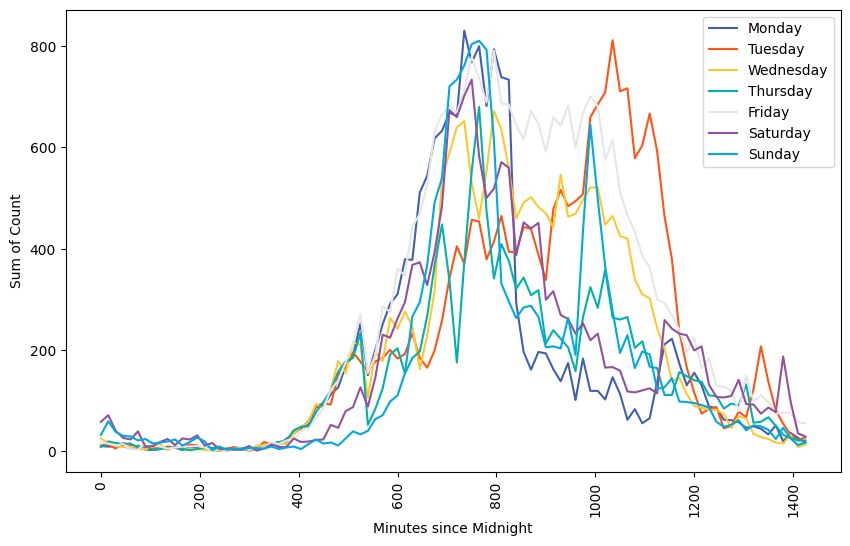

In [178]:
from matplotlib.colors import ListedColormap

df = df_selected_week.groupby("dt").agg(
    {"minutes_since_midnight": "first", "value": "sum", "day_in_week": "first"}
)

# Create a colormap with as many colors as there are weekdays
custom_palette = get_custom_palette()
cmap = ListedColormap(custom_palette[:7])

# Define weekdays
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(10, 6))

# Create a scatter plot for each weekday
for i, day in enumerate(weekdays):
    df_day = df[df["day_in_week"] == i]
    plt.plot(
        df_day["minutes_since_midnight"], df_day["value"], color=cmap(i), label=day
    )

plt.xticks(rotation=90)
plt.xlabel("Minutes since Midnight")
plt.ylabel("Sum of Count")
plt.legend()
plt.show()

### 4.2.2 Clustering the data

For our first clustering model we will use `sklearn.cluster.KMeans`. The steps for creating this model are:
1. Prepare the data.
    * Aggregate the pedestrian flow for both trajectories yielding sum.
    * Resample the data on each day yielding mean and std.
    * Scale the data using `sklearn.preprocessing.StandardScalar` (z = x - u / s)
2. Model the data
    * Use k=4 as an initial cluster value (representing seasonal periodicity)
    * Plot the results
3. Analyse the results
    * Test for different possible values of k
    * Calculate test metrics and compare
We will first need to rescale our dataset to improve model convergence. For this we will use the `sklearn.preprocessing.StandardScaler` which is calculated using z = (x - u) / s and returns a `numpy` array. 

In [179]:
# X = data_resampled['mean']
X = data_resampled

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Shape of scaled dataframe: {X.shape}")

Shape of scaled dataframe: (168, 3)


Now we can cluster the data using the K-Means algorithm. This produces labels and centroids for the clusters. 

In [180]:
from sklearn.cluster import KMeans

N_CLUSTERS = 8

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)

labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

c:\#code\#python\#current\mres-project\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 4.2.3 Visualising the results

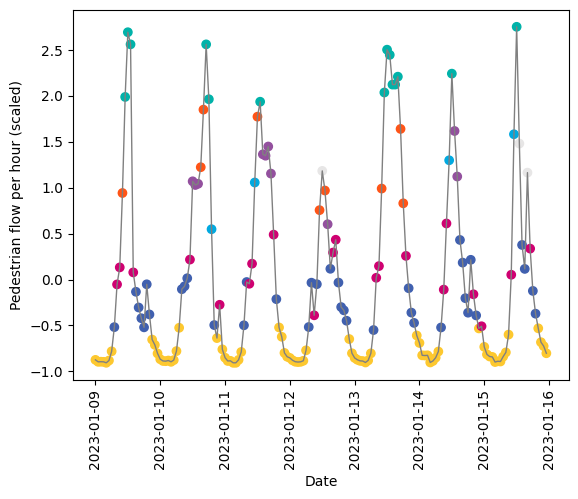

In [181]:
# Convert labels to colors using the colormap
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
label_colors = cmap(labels)

# Create the scatter plot
plt.scatter(data_resampled.index, X[:, 0], c=label_colors)
plt.plot(data_resampled.index, X[:, 0], c="gray", linewidth=1)
plt.xticks(rotation=90)
plt.ylabel("Pedestrian flow per hour (scaled)")
plt.xlabel("Date")
plt.show()

In the plot above we can see that clustering based on hourly points does not really produce anything useful. This is probably because we didnt see any signal at the hourly period during the frequency analysis. Moving forward it might make sense to look at some of the periods that experienced more powerful signals i.e. 12-hour, 24-hour, quarterly and annual.

### 4.2.4 Evaluating the hourly clustered data

In [182]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

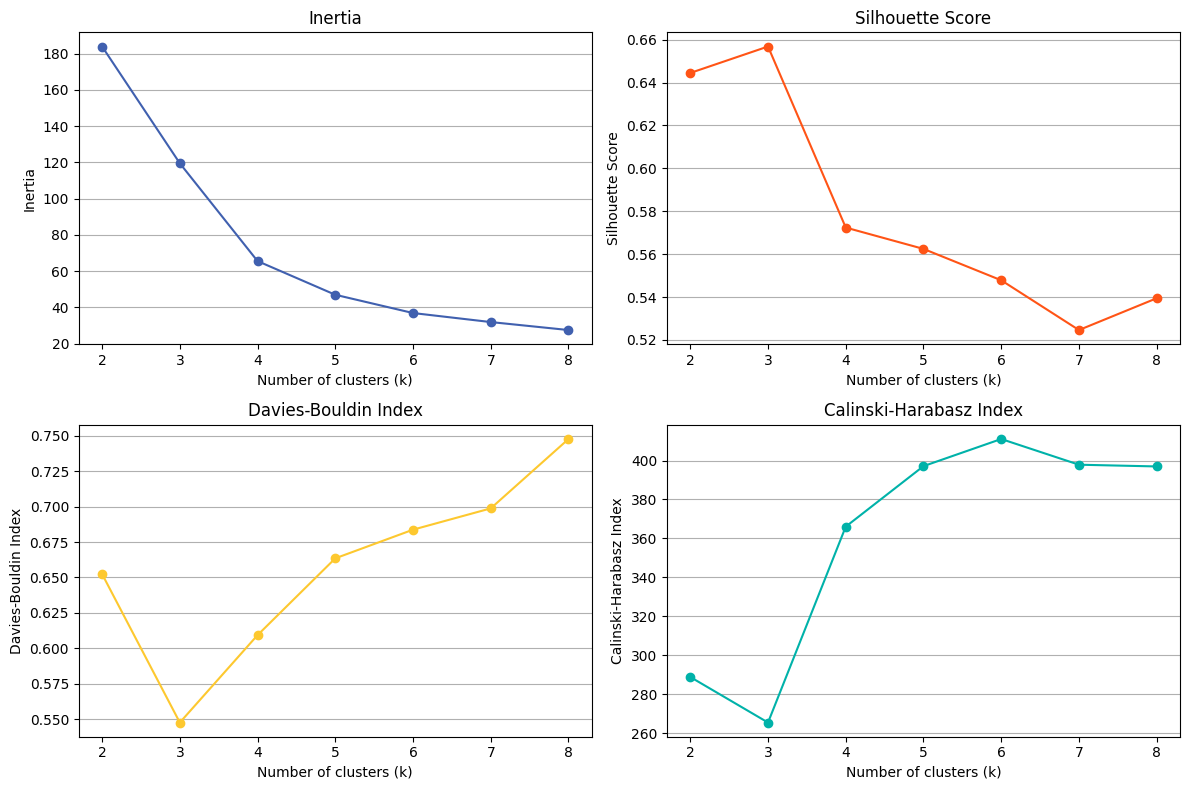

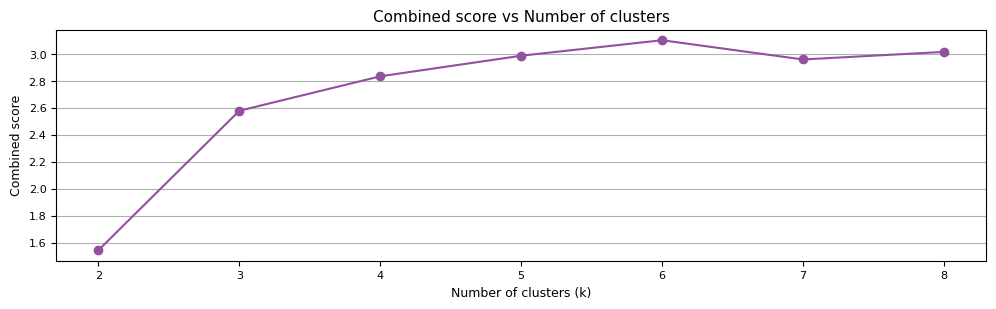

In [183]:
# perform k-means clustering on the entire data


results = []
k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    labels = kmeans.predict(X)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)

    results.append(
        {"k": k, "inertia": inertia, "silhouette": silhouette, "dbi": dbi, "chi": chi}
    )

# convert results to DataFrame
df_results = pd.DataFrame(results)

# plot the four indices
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(df_results["k"], df_results["inertia"], marker="o", c=custom_palette[0])
axs[0, 0].set_title("Inertia")
axs[0, 0].set_xlabel("Number of clusters (k)")
axs[0, 0].set_ylabel("Inertia")
axs[0, 0].grid(True, which="major", axis="y")

axs[0, 1].plot(
    df_results["k"], df_results["silhouette"], marker="o", c=custom_palette[1]
)
axs[0, 1].set_title("Silhouette Score")
axs[0, 1].set_xlabel("Number of clusters (k)")
axs[0, 1].set_ylabel("Silhouette Score")
axs[0, 1].grid(True, which="major", axis="y")

axs[1, 0].plot(df_results["k"], df_results["dbi"], marker="o", c=custom_palette[2])
axs[1, 0].set_title("Davies-Bouldin Index")
axs[1, 0].set_xlabel("Number of clusters (k)")
axs[1, 0].set_ylabel("Davies-Bouldin Index")
axs[1, 0].grid(True, which="major", axis="y")

axs[1, 1].plot(df_results["k"], df_results["chi"], marker="o", c=custom_palette[3])
axs[1, 1].set_title("Calinski-Harabasz Index")
axs[1, 1].set_xlabel("Number of clusters (k)")
axs[1, 1].set_ylabel("Calinski-Harabasz Index")
axs[1, 1].grid(True, which="major", axis="y")

fig.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_FIGURES_PATH, f"Clustering scores.svg"),
    bbox_inches="tight",
    dpi=200,
)
plt.show()

# show combined plots
from sklearn.preprocessing import MinMaxScaler

# initialize the MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_results), columns=df_results.columns, index=df_results.index
)

# we have to maximize silhouette and calinski_harabasz,
# and minimize inertia and davies_bouldin for our clustering to be good.
# therefore, we subtract inertia and davies_bouldin from 1 after normalization.
df_normalized["inertia"] = 1 - df_normalized["inertia"]
df_normalized["dbi"] = 1 - df_normalized["dbi"]

# sum the normalized scores across each row (i.e., for each cluster size)
df_normalized["combined"] = df_normalized.sum(axis=1)

# plot the combined score for each number of clusters
plt.figure(figsize=(12, 3))
plt.plot(
    df_results.index + 2, df_normalized["combined"], marker="o", c=custom_palette[5]
)
plt.xlabel("Number of clusters (k)", fontsize=9)
plt.ylabel("Combined score", fontsize=9)
plt.title("Combined score vs Number of clusters", fontsize=11)
plt.grid(True, which="major", axis="y")
plt.tick_params(labelsize=8)
plt.savefig(
    os.path.join(
        OUTPUT_FIGURES_PATH,
        f"Combined clustering score (normalised and unweighted).svg",
    ),
    bbox_inches="tight",
    dpi=200,
)
plt.show()

## 4.3 Test Design: Iteration 2 (24-Hour Time Period)

### 4.3.1 Read in the complete days dataset

For this we will use a helper function created for this purpose. This function `aggregate_and_preprocess_daily_data` will again group on datetime and aggregate on sum to remove the trajectories information. It will then resample the data on day, and scale the data using the `sklearn.preprocessing.StandardScaler`.

### 4.3.2 Clustering the data at daily aggregations

As some of the data are missing, aggregations at the daily level will use the mean count rather than the sum count as we have used previously. Additionally, only days where there is greater than 95% data completeness will be used. 

In [184]:
west_complete_days_df.head(2)

,dt,value,veh_class,dir,location,category,key,date,time,hour-minutes,...,month-hour,year-month,year-week,hours_since_midnight,minutes_since_midnight,year-quarter,month,quarter,day_in_week,day_of_week
297,2021-12-03,48,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2021-12,2021-12-03,1900-01-01,00:00,...,12 00,2021-12,2021-48,0,0,2021-4,12,4,4,Friday
299,2021-12-03,11,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2021-12,2021-12-03,1900-01-01,00:00,...,12 00,2021-12,2021-48,0,0,2021-4,12,4,4,Friday


In [185]:
from eda_helper import aggregate_and_preprocess_daily_data

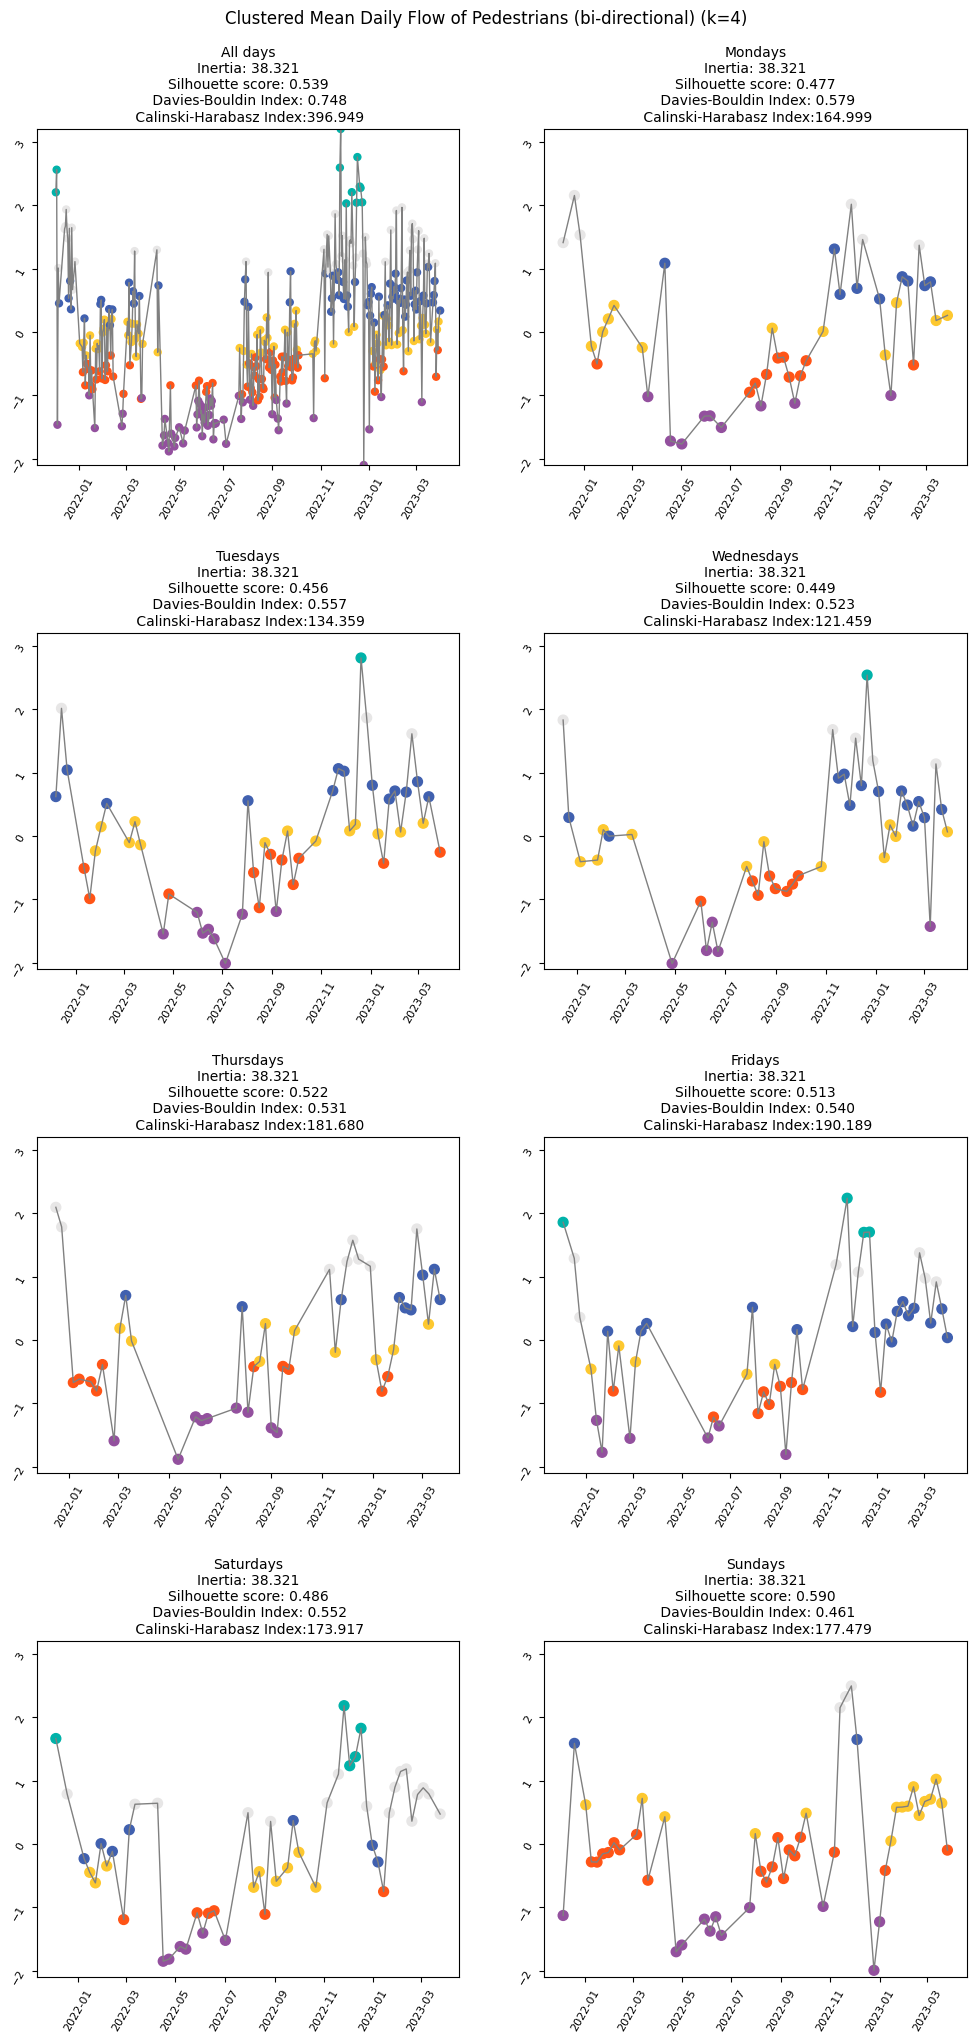

In [186]:
import calendar

N_CLUSTERS = 6

fig, ax = plt.subplots(4, 2, figsize=(12, 24))
fig.suptitle("Clustered Mean Daily Flow of Pedestrians (bi-directional) (k=4)", y=0.93)
fig.subplots_adjust(hspace=0.5)

# list weekday names
days_of_week = list(calendar.day_name)

# perform k-means clustering on the entire data
all_X, all_X_index, all_X_columns = aggregate_and_preprocess_daily_data(
    west_complete_days_df
)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10)
kmeans.fit(all_X)
all_labels = kmeans.predict(all_X)
all_centroids = kmeans.cluster_centers_

# determine the overall min and max y-values across all the data
y_min = np.min(all_X[:, 0])
y_max = np.max(all_X[:, 0])

# set the cluster colors
cmap = ListedColormap(custom_palette[:N_CLUSTERS])
all_label_colors = cmap(all_labels)

# plot all days first at ax[0,0]
ax[0, 0].plot(all_X_index, all_X[:, 0], c="gray", linewidth=1)
ax[0, 0].scatter(all_X_index, all_X[:, 0], c=all_label_colors, s=25)
ax[0, 0].set_title(
    f"All days\nInertia: {kmeans.inertia_:.3f}\nSilhouette score: {silhouette_score(X, labels):.3f}\n Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}\n Calinski-Harabasz Index:{calinski_harabasz_score(X, labels):.3f}",
    fontsize=10,
)
ax[0, 0].tick_params(labelrotation=60, labelsize=8)
ax[0, 0].set_ylim(y_min, y_max)  # set consistent y-limits

# start plotting the rest of the days starting from ax[0,1]
for i in range(7):
    df = west_complete_days_df[west_complete_days_df["day_in_week"] == i % 7]
    X, X_index, X_columns = aggregate_and_preprocess_daily_data(df)

    # use labels from the entire data for consistency
    labels = all_labels[all_X_index.isin(X_index)]
    label_colors = all_label_colors[all_X_index.isin(X_index)]

    ax[(i + 1) // 2, (i + 1) % 2].plot(X_index, X[:, 0], c="gray", linewidth=1)
    ax[(i + 1) // 2, (i + 1) % 2].scatter(X_index, X[:, 0], c=label_colors, s=50)
    ax[(i + 1) // 2, (i + 1) % 2].set_title(
        f"{days_of_week[i % 7]}s\nInertia: {kmeans.inertia_:.3f}\nSilhouette score: {silhouette_score(X, labels):.3f}\n Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}\n Calinski-Harabasz Index:{calinski_harabasz_score(X, labels):.3f}",
        fontsize=10,
    )
    ax[(i + 1) // 2, (i + 1) % 2].tick_params(labelrotation=60, labelsize=8)
    ax[(i + 1) // 2, (i + 1) % 2].set_ylim(y_min, y_max)  # set consistent y-limits

plt.savefig(
    os.path.join(
        OUTPUT_FIGURES_PATH, f"Clustering daily mean flow of pedestrians (by day).svg"
    ),
    bbox_inches="tight",
    dpi=200,
)

From the clustering we can see that the clustering perhaps make a bit more sense now. Looking from left to right we can see that there are multiple sequential points that follow on from one another that are either in the same cluster or in the same adjacent clusters. This seems like a promising start before we start more complicated clustering analysis. However, we need to check the statistical significance of these clusters. 

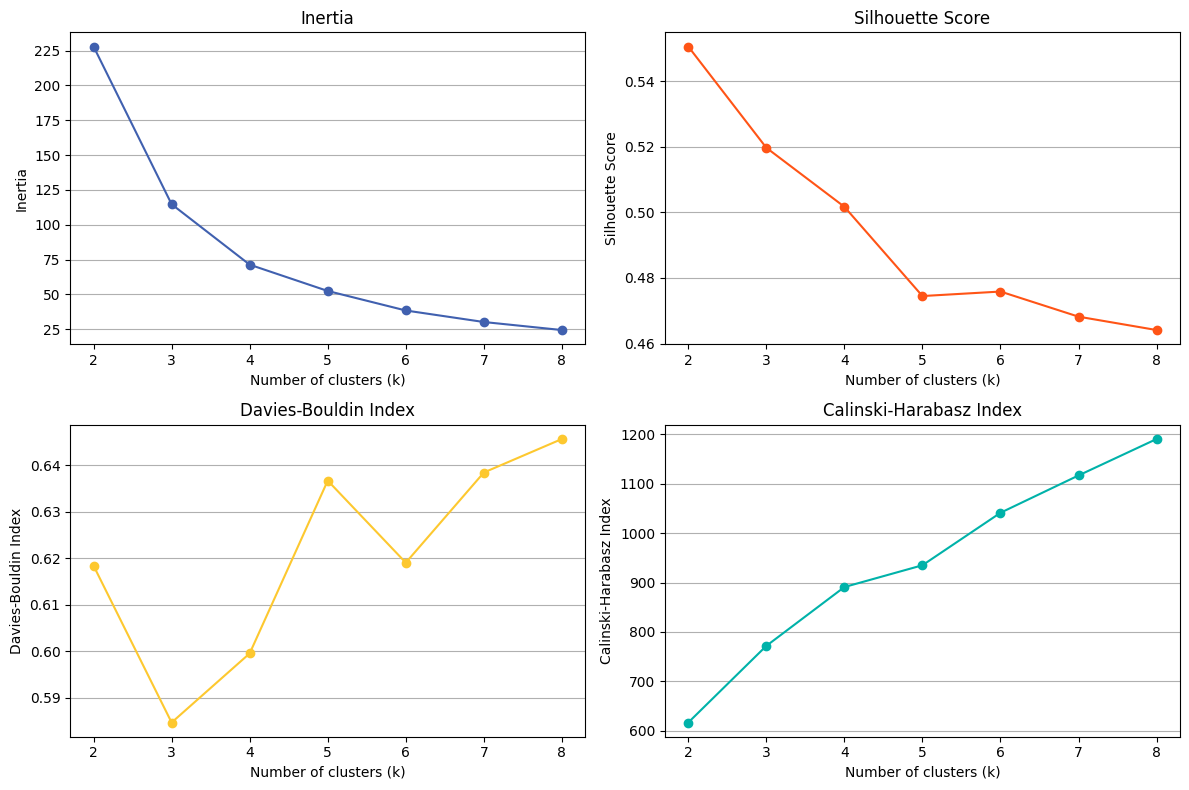

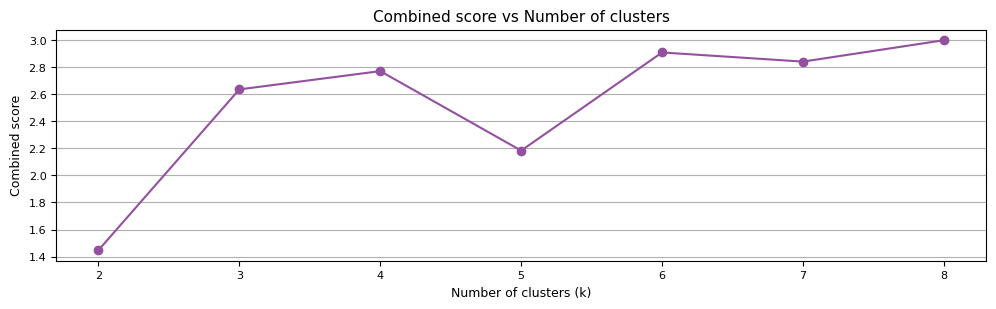

In [187]:
# perform k-means clustering on the entire data
all_X, all_X_index, all_X_columns = aggregate_and_preprocess_daily_data(
    west_complete_days_df
)

results = []
k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(all_X)
    labels = kmeans.predict(all_X)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(all_X, labels)
    dbi = davies_bouldin_score(all_X, labels)
    chi = calinski_harabasz_score(all_X, labels)

    results.append(
        {"k": k, "inertia": inertia, "silhouette": silhouette, "dbi": dbi, "chi": chi}
    )

# convert results to DataFrame
df_results = pd.DataFrame(results)

# plot the four indices
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(df_results["k"], df_results["inertia"], marker="o", c=custom_palette[0])
axs[0, 0].set_title("Inertia")
axs[0, 0].set_xlabel("Number of clusters (k)")
axs[0, 0].set_ylabel("Inertia")
axs[0, 0].grid(True, which="major", axis="y")

axs[0, 1].plot(
    df_results["k"], df_results["silhouette"], marker="o", c=custom_palette[1]
)
axs[0, 1].set_title("Silhouette Score")
axs[0, 1].set_xlabel("Number of clusters (k)")
axs[0, 1].set_ylabel("Silhouette Score")
axs[0, 1].grid(True, which="major", axis="y")

axs[1, 0].plot(df_results["k"], df_results["dbi"], marker="o", c=custom_palette[2])
axs[1, 0].set_title("Davies-Bouldin Index")
axs[1, 0].set_xlabel("Number of clusters (k)")
axs[1, 0].set_ylabel("Davies-Bouldin Index")
axs[1, 0].grid(True, which="major", axis="y")

axs[1, 1].plot(df_results["k"], df_results["chi"], marker="o", c=custom_palette[3])
axs[1, 1].set_title("Calinski-Harabasz Index")
axs[1, 1].set_xlabel("Number of clusters (k)")
axs[1, 1].set_ylabel("Calinski-Harabasz Index")
axs[1, 1].grid(True, which="major", axis="y")

fig.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_FIGURES_PATH, f"Clustering scores.svg"),
    bbox_inches="tight",
    dpi=200,
)
plt.show()

# show combined plots
from sklearn.preprocessing import MinMaxScaler

# initialize the MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_results), columns=df_results.columns, index=df_results.index
)

# we have to maximize silhouette and calinski_harabasz,
# and minimize inertia and davies_bouldin for our clustering to be good.
# therefore, we subtract inertia and davies_bouldin from 1 after normalization.
df_normalized["inertia"] = 1 - df_normalized["inertia"]
df_normalized["dbi"] = 1 - df_normalized["dbi"]

# sum the normalized scores across each row (i.e., for each cluster size)
df_normalized["combined"] = df_normalized.sum(axis=1)

# plot the combined score for each number of clusters
plt.figure(figsize=(12, 3))
plt.plot(
    df_results.index + 2, df_normalized["combined"], marker="o", c=custom_palette[5]
)
plt.xlabel("Number of clusters (k)", fontsize=9)
plt.ylabel("Combined score", fontsize=9)
plt.title("Combined score vs Number of clusters", fontsize=11)
plt.grid(True, which="major", axis="y")
plt.tick_params(labelsize=8)
plt.savefig(
    os.path.join(
        OUTPUT_FIGURES_PATH,
        f"Combined clustering score (normalised and unweighted).svg",
    ),
    bbox_inches="tight",
    dpi=200,
)
plt.show()

## 4.3 Build Model

## 4.4 Assess Model